# Object Detection: R-FCN and SSD-MobileNet

In [1]:
from __future__ import print_function

import os
import time
import random
import numpy as np
import tensorflow as tf
from PIL import Image

from object_detection.utils.visualization_utils import visualize_boxes_and_labels_on_image_array

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

In [2]:
MODEL = 'rfcn' # Use 'rfcn' for R-FCN or 'ssdmobilenet' for SSD-MobileNet
PROTOCOL = 'grpc'  # Use 'grpc' for GRPC or 'rest' for REST
IMAGES_PATH = '/home/<user>/coco/val/val2017' # Edit this to your COCO validation directory

In [3]:
if PROTOCOL == 'grpc':
    import grpc
    import tensorflow as tf
    from tensorflow_serving.apis import predict_pb2
    from tensorflow_serving.apis import prediction_service_pb2_grpc
    SERVER_URL = 'localhost:8500'
elif PROTOCOL == 'rest':
    import requests
    SERVER_URL = 'http://localhost:8501/v1/models/{}:predict'.format(MODEL)

In [4]:
def get_random_image(image_dir):
    image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def visualize(output_dict, image_np):
    new_dict = {}
    if PROTOCOL == 'grpc':
        new_dict['num_detections'] = int(output_dict['num_detections'].float_val[0])
        new_dict['detection_classes'] = np.array(output_dict['detection_classes'].float_val).astype(np.uint8)
        new_dict['detection_boxes'] = np.array(output_dict['detection_boxes'].float_val).reshape((-1,4))
        new_dict['detection_scores'] = np.array(output_dict['detection_scores'].float_val)
        new_dict['instance_masks'] = np.array(output_dict['instance_masks'].float_val)
    elif PROTOCOL == 'rest':
        new_dict['num_detections'] = int(output_dict['num_detections'])
        new_dict['detection_classes'] = np.array(output_dict['detection_classes']).astype(np.uint8)
        new_dict['detection_boxes'] = np.array(output_dict['detection_boxes'])
        new_dict['detection_scores'] = np.array(output_dict['detection_scores'])

    # Visualize the results of a detection
    visualize_boxes_and_labels_on_image_array(
        image_np,
        new_dict['detection_boxes'],
        new_dict['detection_classes'],
        new_dict['detection_scores'],
        {1: {'id': 1, 'name': 'object'}}, # Empty category index
        instance_masks=None,
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure()
    plt.imshow(image_np)

# Test Object Detection

In [5]:
batch_size = 1
np_image = get_random_image(IMAGES_PATH)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



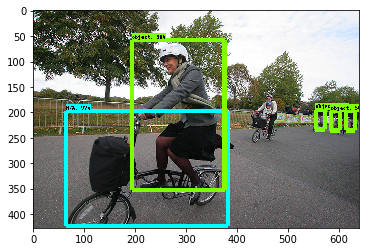

In [6]:
if PROTOCOL == 'grpc':
    np_image = np.repeat(np.expand_dims(np_image, 0), batch_size, axis=0)
    channel = grpc.insecure_channel(SERVER_URL)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'ssdmobilenet'
    request.model_spec.signature_name = 'serving_default'
    request.inputs['inputs'].CopyFrom(tf.contrib.util.make_tensor_proto(np_image))
    result = stub.Predict(request)
    visualize(result.outputs, np_image[0])
elif PROTOCOL == 'rest':
    predict_request = '{"instances" : %s}' % np.expand_dims(np_image, 0).tolist()
    result = requests.post(SERVER_URL, data=predict_request)
    visualize(result.json()['predictions'][0], np_image)

# Measure Performance

In [7]:
def make_request(batch_size):
    if PROTOCOL == 'rest':
        np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0).tolist(), batch_size, axis=0).tolist()
        return '{"instances" : %s}' % np_images
    elif PROTOCOL == 'grpc':
        np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0), batch_size, axis=0)
        channel = grpc.insecure_channel(SERVER_URL)
        stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
        request = predict_pb2.PredictRequest()
        request.model_spec.name = MODEL
        request.model_spec.signature_name = 'serving_default'
        request.inputs['inputs'].CopyFrom(tf.contrib.util.make_tensor_proto(np_images))
        return (stub, request)

def send_request(predict_request):
    if PROTOCOL == 'rest':
        requests.post(SERVER_URL, data=predict_request)
    elif PROTOCOL == 'grpc':
        predict_request[0].Predict(predict_request[1])

def benchmark(batch_size=1, num_iteration=10, warm_up_iteration=2):
    i = 0
    total_time = 0
    for _ in range(num_iteration):
        i += 1
        np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0), batch_size, axis=0)
        predict_request = make_request(batch_size)
        start_time = time.time()
        send_request(predict_request)
        time_consume = time.time() - start_time
        print('Iteration %d: %.3f sec' % (i, time_consume))
        if i > warm_up_iteration:
            total_time += time_consume

    time_average = total_time / (num_iteration - warm_up_iteration)
    print('Average time: %.3f sec' % (time_average))
    print('Batch size = %d' % batch_size)
    if batch_size == 1:
        print('Latency: %.3f ms' % (time_average * 1000))
    print('Throughput: %.3f images/sec' % (batch_size / time_average))

## Real-time Inference (latency, batch_size=1)

In [8]:
benchmark()

Iteration 1: 0.059 sec
Iteration 2: 0.098 sec
Iteration 3: 0.055 sec
Iteration 4: 0.052 sec
Iteration 5: 0.056 sec
Iteration 6: 0.051 sec
Iteration 7: 0.056 sec
Iteration 8: 0.052 sec
Iteration 9: 0.050 sec
Iteration 10: 0.048 sec
Average time: 0.052 sec
Batch size = 1
Latency: 52.392 ms
Throughput: 19.087 images/sec


## Throughput (batch_size=128)

In [9]:
benchmark(batch_size=128)

Iteration 1: 4.414 sec
Iteration 2: 2.699 sec
Iteration 3: 2.654 sec
Iteration 4: 2.409 sec
Iteration 5: 2.485 sec
Iteration 6: 2.476 sec
Iteration 7: 2.457 sec
Iteration 8: 2.497 sec
Iteration 9: 2.575 sec
Iteration 10: 2.539 sec
Average time: 2.511 sec
Batch size = 128
Throughput: 50.967 images/sec
